### Required libraries

In [309]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sys
import numpy as np
import os.path as op
from os import mkdir
import scipy.stats as stats
import nipype.interfaces.fsl as fsl
from subprocess import call
import nibabel as nib

### Utils

In [115]:
def plot_hist(score,title,xlabel):
    h,b = np.histogram(score, bins='auto')
    plt.hist(score,bins=b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    return h

### Parameters

In [278]:
behavFile = 'unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
release = 'Q2'
outScore = 'PMAT24_A_CR'
DATADIR = '/media/paola/HCP/'
PARCELDIR = '/home/paola/parcellations'
parcellation = 'shenetal_neuroimage2013'
overwrite = False
thisRun = 'rfMRI_REST1'
isDataClean = True

if thisRun == 'rfMRI_REST1':
    outMat = 'rest_1_mat'
elif thisRun == 'rfMRI_REST2':
    outMat = 'rest_1_mat'
else:
    sys.exit("Invalid run code")  
    
suffix = '_hp2000_clean' if isDataClean else ''   

### Functions

In [470]:
def makeTissueMasks(subject,fmriRun,overwrite):
    fmriFile = op.join(DATADIR, subject, 'MNINonLinear','Results',fmriRun, fmriRun+suffix+'.nii.gz')
    WMmaskFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'WMmask.nii.gz')
    CSFmaskFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'CSFmask.nii.gz')
    GMmaskFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'GMmask.nii.gz')
    WMCSFmaskFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'WMCSFmask.nii.gz')
    WMCSFGMmaskFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'WMCSFGMmask.nii.gz')
    
    if not op.isfile(WMCSFGMmaskFileout) or overwrite:
        # load ribbon.nii.gz and wmparc.nii.gz
        ribbonFilein = op.join(DATADIR, subject, 'MNINonLinear','ribbon.nii.gz')
        wmparcFilein = op.join(DATADIR, subject, 'MNINonLinear', 'wmparc.nii.gz')
        # make sure it is resampled to the same space as the functional run
        ribbonFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'ribbon.nii.gz')
        wmparcFileout = op.join(DATADIR, subject, 'MNINonLinear', 'Results', fmriRun, 'wmparc.nii.gz')
        # make identity matrix to feed to flirt for resampling
        with open('eye.mat','w') as fid:
            fid.write('1 0 0 0\n0 1 0 0\n0 0 1 0\n0 0 0 1')
        
        flirt_ribbon = fsl.FLIRT(in_file=ribbonFilein, out_file=ribbonFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_ribbon.run()

        flirt_wmparc = fsl.FLIRT(in_file=wmparcFilein, out_file=wmparcFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_wmparc.run()
        
        # load nii (ribbon & wmparc)
        ribbon = nib.load(ribbonFileout).get_data()
        wmparc = nib.load(wmparcFileout).get_data()
        
        # white & CSF matter mask
        # indices are from FreeSurferColorLUT.txt
        
        # Left-Cerebral-White-Matter, Right-Cerebral-White-Matter
        ribbonWMstructures = [2, 41]
        # Left-Cerebral-Cortex, Right-Cerebral-Cortex
        ribbonGMstrucures = [3, 42]
        # Cerebellar-White-Matter-Left, Brain-Stem, Cerebellar-White-Matter-Right
        wmparcWMstructures = [7, 16, 46]
        # Left-Cerebellar-Cortex, Right-Cerebellar-Cortex, Thalamus-Left, Caudate-Left
        # Putamen-Left, Pallidum-Left, Hippocampus-Left, Amygdala-Left, Accumbens-Left 
        # Diencephalon-Ventral-Left, Thalamus-Right, Caudate-Right, Putamen-Right
        # Pallidum-Right, Hippocampus-Right, Amygdala-Right, Accumbens-Right
        # Diencephalon-Ventral-Right
        wmparcGMstructures = [8, 47, 10, 11, 12, 13, 17, 18, 26, 28, 49, 50, 51, 52, 53, 54, 58, 60]
        # Fornix, CC-Posterior, CC-Mid-Posterior, CC-Central, CC-Mid-Anterior, CC-Anterior
        wmparcCCstructures = [250, 251, 252, 253, 254, 255]
        # Left-Lateral-Ventricle, Left-Inf-Lat-Vent, 3rd-Ventricle, 4th-Ventricle, CSF
        # Left-Choroid-Plexus, Right-Lateral-Ventricle, Right-Inf-Lat-Vent, Right-Choroid-Plexus
        wmparcCSFstructures = [4, 5, 14, 15, 24, 31, 43, 44, 63]
        
        # make masks
        WMmask = np.double(np.in1d(ribbon, ribbonWMstructures).tolist() or \
                           np.in1d(wmparc, wmparcWMstructures).tolist() or \
                           np.in1d(wmparc, wmparcCCstructures).tolist() and \
                           not np.in1d(wmparc, wmparcCSFstructures).tolist() and \
                           not np.in1d(wmparc, wmparcGMstructures).tolist())
        CSFmask = np.double(np.in1d(wmparc, wmparcCSFstructures))
        WMCSFmask = np.double((WMmask > 0) | (CSFmask > 0))
        GMmask = np.double(np.in1d(ribbon,ribbonGMstrucures).tolist() or \
        np.in1d(wmparc,wmparcGMstructures).tolist())
        WMCSFGMmask = np.double((WMmask > 0) | (CSFmask > 0) | (GMmask > 0))
        
        # write masks
        ref = nib.load(wmparcFileout)
        WMmask = np.reshape(WMmask,ref.shape)
        img = nib.Nifti1Image(WMmask, ref.affine)
        nib.save(img, WMmaskFileout)
        
        CSFmask = np.reshape(CSFmask,ref.shape)
        img = nib.Nifti1Image(CSFmask, ref.affine)
        nib.save(img, CSFmaskFileout)
        
        GMmask = np.reshape(GMmask,ref.shape)
        img = nib.Nifti1Image(GMmask, ref.affine)
        nib.save(img, GMmaskFileout)
        
        WMCSFmask = np.reshape(WMCSFmask,ref.shape)
        img = nib.Nifti1Image(WMCSFmask, ref.affine)
        nib.save(img, WMCSFmaskFileout)
        
        WMCSFGMmask = np.reshape(WMCSFGMmask,ref.shape)
        img = nib.Nifti1Image(WMCSFGMmask, ref.affine)
        nib.save(img, WMCSFGMmaskFileout)

In [471]:
subject = op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))
print subject
fmriRun = op.basename(op.dirname(fmriFile))
print fmriRun
makeTissueMasks(subject,fmriRun,True)

100307
rfMRI_REST1_LR


In [268]:
def Finn_loadandpreprocess(fmriFile, parcellation, overwrite):
    subject = op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))
    fmriRun = op.basename(op.dirname(fmriFile))
    ResultsDir = op.join(DATADIR,'Results')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,'Finn')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)

    if parcellation=='shenetal_neuroimage2013':
        uniqueParcels = range(268)
    else:
        print "Invalid parcellation code"
        return
    
    for iParcel in range(len(uniqueParcels)):
        parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel))
        if not op.isfile(parcelMaskFile):
            print 'Making a binary volume mask for each parcel'
            mymaths = fsl.maths.MathsCommand(in_file=op.join(PARCELDIR, parcellation,'fconn_atlas_150_2mm.nii'),\
                out_file=parcelMaskFile, args='-thr {:.1f} -uthr {:.1f}'.format(iParcel-0.1, iParcel+0.1)) 
            mymaths.run()
    if not op.isfile(fmriFile):
        print fmriFile, 'does not exist'
        return
    
    tsDir = op.join(op.dirname(fmriFile),parcellation)
    if not op.isdir(tsDir): mkdir(tsDir)
    alltsFile = op.join(ResultsDir,subject+'_'+fmriRun+'.txt')
    alltsGMFile = op.join(ResultsDir,subject+'_'+fmriRun+'_GM.txt')
    if not (op.isfile(alltsFile)) or not (op.isfile(alltsGMFile)) or overwrite:
        fmriFile_prepro = op.join(DATADIR,subject,'MNINonLinear','Results',\
                                 fmriRun, fmriRun+'_FinnPrepro.nii.gz')
        # make WM, CSF, GM masks
        if not op.isfile(op.join(DATADIR,subject,'MNINonLinear','Results',\
                                 fmriRun, fmriRun+'GMmask.nii.gz')):
            print 'TODO: makeTissueMasks(subject,fmriRun)'
        
        # perform preprocessing (if not already done)
        if not op.isfile(fmriFile_prepro):
            print 'TODO: Finn_preprocess(fmriFile)'
            
        # calculate signal in each of the nodes by averaging across all voxels in node
        print 'Extracting mean data from',str(len(uniqueParcels)),'parcels for ',fmriFile_prepro
        subjectParcelDir = op.join(DATADIR,subject,'MNINonLinear','Results','parcellations')
        if not op.isdir(subjectParcelDir): mkdir(subjectParcelDir)
        if not op.isdir(op.join(subjectParcelDir,parcellation)): mkdir(op.join(subjectParcelDir,parcellation))
        
        for iParcel in range(len(uniqueParcels)):
            parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel))
            GMmaskFile = op.join(DATADIR,subject,'MNINonLinear','Results',fmriRun,'GMMask.nii.gz')
            # intersect GM & parcel
            parcelGMMaskFile = op.join(subjectParcelDir,parcellation,'GMparcel{:03d}.nii'.format(iParcel))
            mymaths = fsl.maths.MathsCommand(in_file=parcelMaskFile,\
                out_file=parcelGMMaskFile, args='-mul '+GMmaskFile)
            mymaths.run()
            tsFile = op.join(tsDir,'parcel{:03d}.txt'.format(iParcel))
            if not op.isfile(tsFile):
                # simply average the voxels within the mask
                meants = fsl.meants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelMaskFile)
                meants.run()
                
            tsFile = op.join(tsDir,'GMparcel{:03d}.txt'.format(iParcel))    
            if not op.isfile(tsFile):
                # simply average the voxels within the mask
                meants = fsl.meants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelGMMaskFile)
                meants.run()
                
        # concatenate all ts
        print 'Concatenating data'
        cmd = 'paste '+op.join(tsDir,'parcel*.txt')+' > ',alltsFile
        call(cmd)
        cmd = 'paste '+op.join(tsDir,'GMparcel*.txt')+' > ',alltsGMFile
        call(cmd)
        
            
        

In [ ]:
Finn_loadandpreprocess(fmriFile, parcellation, overwrite)

### Get subjects

In [113]:
df = pd.read_csv(behavFile)

# select subjects according to release
if release == 'Q2':
    ind = (df['Release'] == 'Q2') \
    | (df['Release'] == 'Q1')
elif release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
    
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) \
        & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True) \
        & (df['RS-fMRI_Count']==4))
                
df = df[ind]  

# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
print 'Selected', str(df.shape[0]), 'from the release',release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
tmpAgeRanges = sorted(df['Age'].unique())
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[outScore]

Selected 125 from the release Q2
Number of males is: 40
Age range is 22 - 35


### Score distribution

array([ 3,  7, 10, 10, 15, 17, 19, 27, 17])

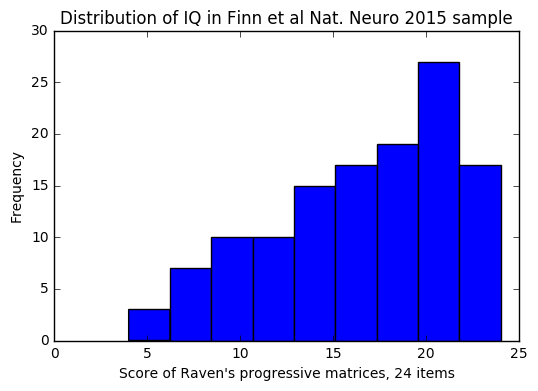

In [117]:
plot_hist(score, 'Distribution of IQ in Finn et al Nat. Neuro 2015 sample', \
          'Score of Raven\'s progressive matrices, 24 items')

### Exclusion of high-motion subjects
Further exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)

In [ ]:
ResultsDir = op.join(DATADIR, 'Results')
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, 'Finn')
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, parcellation)
if not op.isdir(ResultsDir): mkdir(ResultsDir)

PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
excludeSub = list()

for iSub in range(len(subjects)):
    RelRMSMeanFile = op.join(DATADIR, str(subjects[iSub]), 'MNINonLinear','Results', \
                                 thisRun+'_zz', 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        print '{} {:.3f} {:.3f}'.format(subjects[iSub], RelRMSMean[iSub,0], RelRMSMean[iSub,1])
        if np.mean(RelRMSMean[iSub,:]) > 0.141:
            print subjects[iSub], ': too much motion, exclude'
            excludeSub.append(iSub)
            continue
     
    for iPEdir in range(len(PEdirs)):
        PEdir=PEdirs[iPEdir]
        fmriFile = op.join(DATADIR, str(subjects[iSub]), 'MNINonLinear', 'Results', \
                           thisRun+'_'+PEdir, thisRun+'_'+PEdir+suffix+'.nii.gz')
        if not op.isfile(fmriFile):
            print str(subjects[iSub]), 'missing', fmriFile, ', exclude'
            excludeSub.append(iSub)
            continue
        
        if not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+thisRun+'_'+PEdir+'.txt'))) \
        or not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+thisRun+'_'+PEdir+'._GMtxt'))) \
        or overwrite:
            print 'load and preprocess'
            Finn_loadandpreprocess(fmriFile, parcellation, overwrite)
        else:
            print subject[iSub], ' : ', PEdir, 'results already computed; skipping'

indkeep = np.setdiff1d(range(len(subjects)),excludeSub, assume_unique=True)

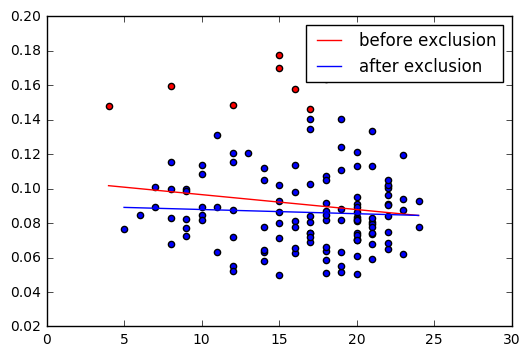

With all subjects: corr(IQ,motion) = -0.154 (p = 0.087)
After discarding high movers: corr(IQ,motion) = -0.056 (p = 0.552)


In [214]:
plt.scatter(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),c='b')
plt.scatter(score[excludeSub],np.mean(RelRMSMean[excludeSub,:],axis=1),c='r')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),1)
z2 = np.polyfit(score,np.mean(RelRMSMean,axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[indkeep])
fit2 = p2(score)
# get the coordinates for the fit curve
c1_x = [np.min(score[indkeep]),np.max(score[indkeep])]
c1_y = p1(c1_x)
c2_x = [np.min(score),np.max(score)]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1))
rho2,p2 = stats.pearsonr(score,np.mean(RelRMSMean,axis=1))                         
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)